# Analyzing Antlr Pattern Evolution, MSR - 3

In [1]:
# _importing required libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
%matplotlib inline

In [2]:
# _creating default figure size of matplotlib
plt.rcParams['figure.figsize'] = 12.0, 7.0

**Custom methods for Matplotlib Visualization**

In [3]:
def show_line_graph(x_values, total_y_values, listener_y_values, visitor_y_values,x_label, y_label, title):
    plt.plot(x_values, total_y_values, label= 'Total Complexity')
    plt.plot(x_values, listener_y_values, label= 'Listener Complexity')
    plt.plot(x_values, visitor_y_values, label= 'Visitor Complexity')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig('results/'+'avg_commit_comp_linegraph.png', bbox_inches='tight')
    plt.show()
    plt.clf()

In [4]:
def show_bar_graph(x_values, y_values_1, y_values_2, x_label, y_label, y_label_2, labels, title_1, title_2):
    
    fig, (axes_1, axes_2) = plt.subplots(nrows=2, sharex=True)
    
    axes_1.bar(x_values,y_values_1)
    axes_2.bar(x_values,y_values_2)
    
    axes_1.set_ylabel(y_label)
    axes_2.set_xlabel(x_label)
    axes_2.set_ylabel(y_label_2)
    
    axes_1.get_shared_x_axes().join(axes_1, axes_2)
    axes_2.autoscale()
    axes_2.set_xticks(x_values)
    axes_2.set_xticklabels(labels)
    axes_1.set_title(title_1)
    axes_2.set_title(title_2)
    
    plt.tight_layout()
    plt.savefig('results/'+'antlr_method_cnts_bargraph.png', bbox_inches='tight')
    plt.show()
    plt.clf()

In [5]:
def show_pie_chart(data_1, data_2, data_3, labels, explode, title):

    fig, (axes_1, axes_2, axes_3) = plt.subplots(nrows=1, ncols=3)
    
    p1 = axes_1.pie(data_1, explode= explode, shadow= True, autopct= '%1.1f%%', startangle=90)
    axes_1.set_title('After Commit 1')
    p2 = axes_2.pie(data_2, explode= explode, shadow= True, autopct= '%1.1f%%', startangle=90)
    axes_2.set_title('After Commit 5')
    p3 = axes_3.pie(data_3, explode= explode, shadow= True, autopct= '%1.1f%%', startangle=90)  
    axes_3.set_title('After Commit 10')

    # Create the legend
    fig.legend([p1, p2, p3],     # The line objects
               labels=labels,   # The labels for each line
               loc="upper right",   # Position of legend
               borderaxespad=0.1,    # Small spacing around legend box
               )
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig('results/'+'repo_pattern_piechart.png', bbox_inches='tight')
    plt.show()
    plt.clf()

In [6]:
def save_individual_plots(timestamp_list, listener_list, visitor_list, commit_complexity_diff_list, title):
    
    plt.plot(timestamp_list,listener_list,marker='x', color='y',label="listener")
    plt.plot(timestamp_list,visitor_list,marker='x', color='b',label="visitor")
    plt.plot(timestamp_list,commit_complexity_diff_list,marker='x',color='g',label="both")
    
    plt.xlabel('Days of Development')
    plt.ylabel('Antlr-pattern Complexity')
    
    plt.legend()
    plt.title(title + " Project Development")
    plt.savefig('results/' + title.replace('/', '_') + '.png', bbox_inches='tight')
    plt.clf()

**Methods to handle specific task**

In [7]:
# _this method returns time in seconds (to get commit timestamp data in seconds)
def get_time_in_seconds(data):
    return (time.mktime(datetime.datetime.strptime(data, "%Y-%m-%d").timetuple()))

In [8]:
# _this method returns the counts of repositories which are having either listener or visitor or both respectively
def get_pattern_cnt_with_commit(commit_id):
    
    # _initializing counts to zero
    listener_repo_cnt = 0
    visitor_repo_cnt = 0
    both_listener_visitor_cnt = 0
    
    # _filtering commits based on the commit id
    repo_commit_bar_df = repo_commit_df.loc[repo_commit_df['commit_group_id'] == commit_id]
    
    # _incrementing pattern count with respect to pattern complexity of the repository
    for listener_comp, visitor_comp in zip(repo_commit_bar_df['listener_complexity'], repo_commit_bar_df['visitor_complexity']):
        if listener_comp > 0 and visitor_comp > 0:
            both_listener_visitor_cnt += 1
        elif listener_comp > 0:
            listener_repo_cnt += 1
        elif visitor_comp > 0:
            visitor_repo_cnt += 1
            
    return listener_repo_cnt, visitor_repo_cnt, both_listener_visitor_cnt

In [9]:
# _this method creates a map(list of tuples basically) which holds the information of repository and its majority complexity pattern
def get_repo_pattern_map(repo_pattern_comp_df):
    
    # _initializng list to empty
    repo_pattern_list = []
    
    # _a repository is assigned as visitor or listener, based on the respective complexity
    # _repo pattern = max_complexity(listener_complexity, visitor_complexity)
    for repo_id, listener_cnt, visitor_cnt in zip(repo_pattern_comp_df['repo_index'], repo_pattern_comp_df['listener_complexity'], repo_pattern_comp_df['visitor_complexity']):
        
        if listener_cnt > visitor_cnt:
            repo_pattern_list.append((repo_id, 'listener'))
        elif visitor_cnt > listener_cnt:
            repo_pattern_list.append((repo_id, 'visitor'))
    
    return repo_pattern_list

In [10]:
# _this method generates commit and file data readily loaded to pandas dataframe - tuple -- row in a dataframe
def get_commit_complexity_data(repo_id, commit):
    
    # _initializing the complexities to zero
    listener_complexity = 0
    visitor_complexity = 0
    
    # _complexity of Antlr pattern = sum(method_counts in all antlr files after that particular commit) 
    for antlr_file in commit['_changed_files_list']:
        listener_complexity += (antlr_file['_enter_cnt'] + antlr_file['_exit_cnt'])
        visitor_complexity += antlr_file['_visit_cnt']
        
    return (repo_id, commit['_commit_index'], commit['_sha_id'], commit['_timestamp'], (listener_complexity + visitor_complexity), listener_complexity, visitor_complexity)

**main()/ Starting point of the program**

In [11]:
# _this method is the satrting point of this notebook
# _consolidated json file is being parsed and transformaed to pandas dataframe
with open('final_repo_data.json', "r", encoding='utf-8', errors='ignore') as infile:
    
    # _initializing lists to empty list
    repo_info_list = []
    repo_commit_data_list = []
    
    # _using in-built json library, loading file data to a json object
    json_object_list = json.load(infile, strict=False)
    
    # _analyzing each repo object from the consolidated json object
    for repo in json_object_list:
        repo_info_list.append((repo['_repo_id'], repo['_repo_name'], repo['_total_commits'], len(repo['_commit_history'])))
        
        # _analyzing each commit object inside a repo object
        for commit in repo['_commit_history']:
            repo_commit_data_list.append(get_commit_complexity_data(repo['_repo_id'], commit))

In [12]:
# _transform list of tuples to pandas dataframe - holds only repo information
repo_info_df = pd.DataFrame(repo_info_list, columns=['repo_index', 'repo_name', 'repo_total_commits', 'mined_commits'])
repo_info_df.set_index('repo_index', inplace=True) # _setting index to unique repo id
repo_info_df.sort_values('repo_index', ascending=True, inplace=True) # _sorting dataframe based on repo index
repo_info_df

,repo_name,repo_total_commits,mined_commits
repo_index,,,
1,4455jkjh/Apktool-android,9,5
2,52Jolynn/SqlParser,36,10
3,Adrodoc/MPL,703,10
4,AlanHohn/antlr4-python,7,2
5,Andyccs/sqat,181,10
...,...,...,...
434,zendesk/maxwell,2965,10
435,zhegexiaohuozi/JsoupXpath,168,10
436,zhunki/skyfire,25,10


**Data-Preprocessing**

In [13]:
# _data_filtering - removing insignificant data
# _considering the commits which have atleast 10 mined commits, to keep uniformity in the distribution 
repo_info_df = repo_info_df.loc[repo_info_df['mined_commits'] > 9]
repo_info_df.shape

(411, 3)

In [14]:
# _transform list of tuples to pandas dataframe - holds the information of repo, commit and also complexity 
repo_commit_df = pd.DataFrame(repo_commit_data_list, columns=['repo_index', 'commit_id', 'hash_id', 'timestamp', 'complexity', 'listener_complexity', 'visitor_complexity'])
repo_commit_df.sort_values(['repo_index', 'commit_id'], ascending=[True, True], inplace=True)
repo_commit_df.head()

,repo_index,commit_id,hash_id,timestamp,complexity,listener_complexity,visitor_complexity
2164,1,1,2e0679cb43e155549d364529801c070fac311db1,2019-02-23 17:00:54+00:00,0,0,0
2165,1,4,8c212d9f4352788498e802acd961fed72ef6e35f,2019-02-24 20:53:29+08:00,50,0,50
2166,1,6,fb1f556579e93c7bd23a4a9bd946533043e618fc,2019-03-10 22:31:35+08:00,0,0,0
2167,1,7,6b6abb2bf9c6b0feccd658053a531cb75280e8f5,2019-04-08 19:10:33+08:00,111,0,111
2168,1,9,4c1841a582d1e79cb87d9221f948cf06a63e8384,2019-05-16 21:51:33+08:00,111,0,111


In [15]:
# _appling the filtered repos on commit dataframe
repo_index_list = list(repo_info_df.index)
repo_commit_df = repo_commit_df.loc[repo_commit_df['repo_index'].isin(repo_index_list)]
repo_commit_df.shape

(4110, 7)

In [16]:
# _initializing commit rank list to emplty list 
commit_group_index_list = []
sample_list = range(1, 11)

# _assigning rank for each commit
for value in range(len(repo_info_df.index)):
    commit_group_index_list.extend(sample_list)

# _adding new column to the dataframe to signify commit rank
repo_commit_df['commit_group_id'] = commit_group_index_list
repo_commit_df.shape

(4110, 8)

In [17]:
# _finding repositories which has antlr files in any commit(perforing the oppsoite/ filtering non-zero antlr complexity)
repo_complexity_df = repo_commit_df.groupby('repo_index', as_index=False)['complexity'].sum()
repo_complexity_df = repo_complexity_df.loc[repo_complexity_df['complexity'] != 0.0]
repo_complexity_df.shape

(264, 2)

In [18]:
# _data_filtering - removing outliers
# _filtering all repositories which has no antlr file in any commit
repo_commit_df = repo_commit_df.loc[repo_commit_df['repo_index'].isin(repo_complexity_df.repo_index)]
repo_commit_df.reset_index(drop=True, inplace=True) # _resetting a linear Index
repo_commit_df.shape

(2640, 8)

**Plotting Individual Antlr Complexity Development Distribution**

In [19]:
for repo_id in range(0,len(repo_commit_df),10):
    
    # initializing the plot data lists to empty lists
    timestamp_list = [0] *10 
    commit_complexity_diff_list = [0] *10
    listener_list = [0] *10
    visitor_list = [0] *10
    
    # _iterating through all commits to load complexity for each of 10 linear commits
    for commit_id in range(repo_id,repo_id+10,1):
        commit_index = int(commit_id%10)
        timestamp_list[commit_index] = get_time_in_seconds((repo_commit_df['timestamp'][commit_id])[0:10])
        commit_complexity_diff_list[commit_index] = repo_commit_df['complexity'][commit_id]
        listener_list[commit_index] = repo_commit_df['listener_complexity'][commit_id]
        visitor_list[commit_index] = repo_commit_df['visitor_complexity'][commit_id]
        
    
    # _framing x-axes for the plots
    start_timestamp = timestamp_list[0]
    for j in range(len(timestamp_list)):
        timestamp_list[j] -= start_timestamp # _finding time difference from the previous commit
        timestamp_list[j] = timestamp_list[j]/86400 # _getting time in seconds with respect to days (1 day = 24 x 60 x 60 secs)
    
    index = repo_commit_df.loc[repo_commit_df.index==repo_id]['repo_index'].values[0]
    title = repo_info_df.loc[repo_info_df.index == index]['repo_name'].values[0] # _getting repo name
    
    # _plot all individual for analysis reference 
    save_individual_plots(timestamp_list, listener_list, visitor_list, commit_complexity_diff_list, title)

<Figure size 864x504 with 0 Axes>

**Sample Antlr Project Development**

<img src="results/Riverside-Software_sonar-openedge.png">

**Supporting RQ_1: All Repositories Complexity Distribution of linear commits**

In [20]:
# _calculating the average complexity of commits by group them with respect to their commit rank
avg_commit_comp_df = repo_commit_df.groupby('commit_group_id', as_index=False)['complexity'].mean()
total_y_values = avg_commit_comp_df['complexity']

# _calculating the average listener_complexity of commits by group them with respect to their commit rank
avg_commit_comp_df = repo_commit_df.groupby('commit_group_id', as_index=False)['listener_complexity'].mean()
listener_y_values = avg_commit_comp_df['listener_complexity']

# _calculating the average visitor_complexity of commits by group them with respect to their commit rank
avg_commit_comp_df = repo_commit_df.groupby('commit_group_id', as_index=False)['visitor_complexity'].mean()
visitor_y_values = avg_commit_comp_df['visitor_complexity']

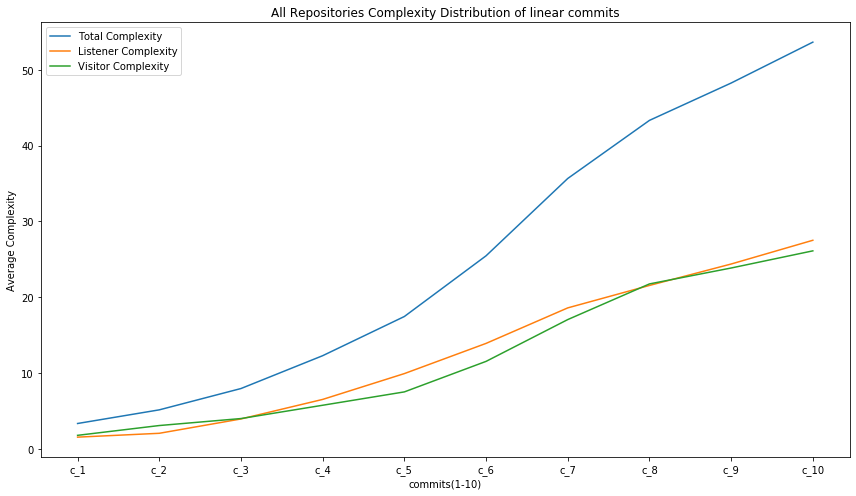

<Figure size 864x504 with 0 Axes>

In [21]:
# _intializing line graph details 
x_values = ['c_'+str(value) for value in avg_commit_comp_df['commit_group_id']]
# _plotting line graphs with (Avg complexity vs linear commits)
show_line_graph(x_values, total_y_values, listener_y_values, visitor_y_values, "commits(1-10)", "Average Complexity", "All Repositories Complexity Distribution of linear commits")

**Supporting RQ_1: Antlr4 complexity evolution over Development time**

In [22]:
#create a list of the means of the complexity from all repositories in 10 percentage steps
ten_time_diff_list= []
for i in range(10):
    ten_time_diff_list.append([])

In [23]:
for repo_id in range(0,len(repo_commit_df),10): # _considering step of 10, to take 10 commits from repo    
    first_ts = get_time_in_seconds((repo_commit_df['timestamp'][repo_id])[0:10]) # _get timestamp in seconds for the first commit
    last_ts = get_time_in_seconds((repo_commit_df['timestamp'][repo_id+9])[0:10]) # _get timestamp in seconds for the last commit
    diff_ts = last_ts-first_ts # _take difference
    
    bar_borders = []
    for j in range(1,11):
        bar_borders.append(first_ts+(j+0.0)/10*diff_ts)
    
    commit_complexity_diff_list = [0] * 10 # _initializing a empty list to store complexity at a particular time difference                                          
    for commit_id in range(repo_id,repo_id+10,1):
        act_ts = get_time_in_seconds((repo_commit_df['timestamp'][commit_id])[0:10]) # _get commit timestamp in seconds
     
        for j in range(10):
            if(act_ts <= bar_borders[j]): # _check whether commit comes under a particular time difference
                commit_complexity_diff_list[j] = repo_commit_df['complexity'][commit_id] # _override the complexity
                
    for j in range(10):
        ten_time_diff_list[j].append(commit_complexity_diff_list[j]) # _split the complexity to the respective time difference

In [24]:
# _initializing bar graph data with empty list
x_labels = []
means = []
deltas = []

# _making 10 divisions of development period
x_values = np.arange(10)
for i in range(10):
    means.append(sum(ten_time_diff_list[i])/len(ten_time_diff_list[i])) # _taking mean - sum/10 at each time difference level
    x_labels.append(str((1+i)*10)+"%")

deltas.append(means[0])
for i in range(1,10):
    deltas.append(means[i]-means[i-1])

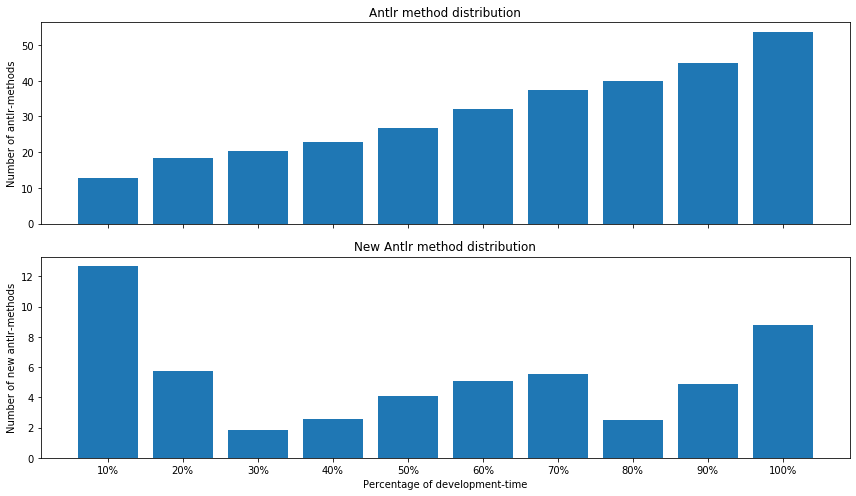

<Figure size 864x504 with 0 Axes>

In [25]:
show_bar_graph(x_values, means, deltas, "Percentage of development-time", "Number of antlr-methods", "Number of new antlr-methods", x_labels, "Antlr method distribution",  "New Antlr method distribution")

**Supporting RQ_2: Repository with Antlr Pattern switches**

In [26]:
# _Finding Pattern Switches from the first commit to last commit
# _assigning pattern on basis of max complexity after commit 1
repo_pattern_comp_df = repo_commit_df.loc[repo_commit_df['commit_group_id'] == 1]
repo_pattern_list_1 = get_repo_pattern_map(repo_pattern_comp_df)

In [27]:
# _assigning pattern on basis of max complexity after commit 10
repo_pattern_comp_df = repo_commit_df.loc[repo_commit_df['commit_group_id'] == 10]
repo_pattern_list_10 = get_repo_pattern_map(repo_pattern_comp_df)

In [28]:
# _transforming repository pattern information to a pandas dataframe
repo_pattern_df_1 = pd.DataFrame(repo_pattern_list_1, columns=['repo_index', 'start_antlr_pattern'])
repo_pattern_df_1.set_index('repo_index', inplace=True)
repo_pattern_df_10 = pd.DataFrame(repo_pattern_list_10, columns=['repo_index', 'end_antlr_pattern'])
repo_pattern_df_10.set_index('repo_index', inplace=True)

# _merging commit 1 and commit 10 pattern dataframes based on the repo index
repo_pattern_df = pd.merge(repo_pattern_df_1, repo_pattern_df_10, on = 'repo_index', how='outer')
repo_pattern_df

,start_antlr_pattern,end_antlr_pattern
repo_index,,
6,listener,listener
7,visitor,visitor
9,listener,listener
18,visitor,visitor
20,listener,listener
...,...,...
433,NaN,visitor
434,NaN,listener
435,NaN,visitor


In [29]:
# _initializing pattern switch count to zero
pattern_begin_listener_cnt = 0
pattern_begin_visitor_cnt = 0
pattern_switch_cnt = 0
pattern_none_listener_cnt = 0
pattern_none_visitor_cnt = 0

# _incrementing count, if there are any switch (start pattern is different from end pattern)
for repo_index, start_pattern, end_pattern in zip(repo_pattern_df.index, repo_pattern_df['start_antlr_pattern'], repo_pattern_df['end_antlr_pattern']):
    if start_pattern in ('visitor', 'listener') and end_pattern in ('visitor', 'listener'):     
        
        if start_pattern == 'visitor':
            pattern_begin_visitor_cnt +=1 
        elif start_pattern == 'listener':
            pattern_begin_listener_cnt += 1
        
        if start_pattern != end_pattern:
            print(f'Repository {repo_index} switched from {start_pattern} pattern to {end_pattern}')
            pattern_switch_cnt += 1
        
    elif start_pattern not in ('visitor', 'listener') and end_pattern == 'visitor':
        pattern_none_visitor_cnt += 1
    elif start_pattern not in ('visitor', 'listener') and end_pattern == 'listener':
        pattern_none_listener_cnt += 1

In [30]:
print(f'No.of Repositories having listener pattern at the beginning - {pattern_begin_listener_cnt}')
print(f'No.of Repositories having visitor pattern at the beginning - {pattern_begin_visitor_cnt}')   
print(f'No.of Repositories switched antlr patterns - {pattern_switch_cnt}')
print(f'No.of Repositories which adopted listener pattern at the end - {pattern_none_listener_cnt}')
print(f'No.of Repositories which adopted visitor pattern at the end - {pattern_none_visitor_cnt}')

No.of Repositories having listener pattern at the beginning - 12
No.of Repositories having visitor pattern at the beginning - 18
No.of Repositories switched antlr patterns - 0
No.of Repositories which adopted listener pattern at the end - 117
No.of Repositories which adopted visitor pattern at the end - 115


**We tried find repositories where there is an antlr pattern switch based on complexities after commit 1 and commit 10, but we didn't find any repository which has different antlr patterns at the beginning and end. However, we consolidated all repositories and tried to find pattern distribution at Commit level(1, 5, 10).**

In [31]:
#_ as pattern switches are very insignificant, we are analyzing the percentage of patterns after commits
# _finding listener, visitor and both (l,v) counts after commit 1, 5 and 10 respectively
listener_cnt_1, visitor_cnt_1, listener_visitor_1 = get_pattern_cnt_with_commit(1)
listener_cnt_5, visitor_cnt_5, listener_visitor_5 = get_pattern_cnt_with_commit(5)
listener_cnt_10, visitor_cnt_10, listener_visitor_10 = get_pattern_cnt_with_commit(10)

In [32]:
pie_chart_datapoints_1 = [listener_visitor_1, listener_cnt_1, visitor_cnt_1]
pie_chart_datapoints_5 = [listener_visitor_5, listener_cnt_5, visitor_cnt_5]
pie_chart_datapoints_10 = [listener_visitor_10, listener_cnt_10, visitor_cnt_10]
pie_chart_labels = ['Listener and Visitor', 'Only Listener', 'Only Visitor']

/home/praveen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  app.launch_new_instance()


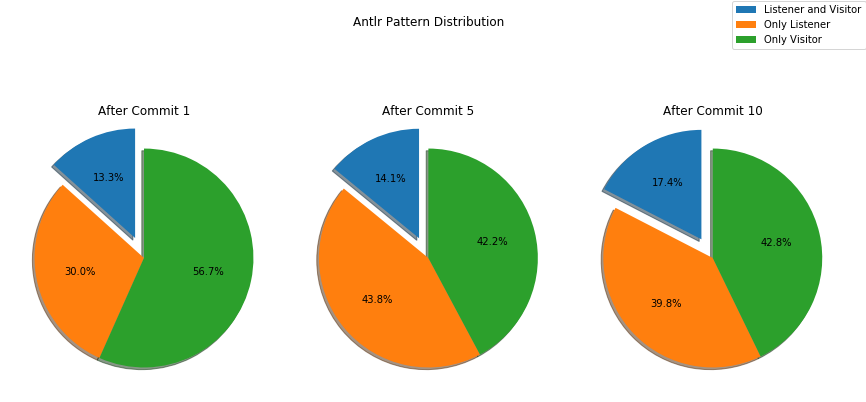

<Figure size 864x504 with 0 Axes>

In [33]:
# _analyzing repository pattern counts (in percentages), to get the information pattern adoption over the time of all commits
show_pie_chart(pie_chart_datapoints_1, pie_chart_datapoints_5, pie_chart_datapoints_10, pie_chart_labels, [0.2, 0, 0], 'Antlr Pattern Distribution')